In [28]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from graph_nets import blocks
from graph_nets import graphs
from graph_nets import modules
from graph_nets import utils_np
from graph_nets import utils_tf

import my_graph_tools as mgt
import numpy as np
import tensorflow as tf
import h5py
import sonnet as snt
import matplotlib.pyplot as plt

from importlib import reload
from progressbar import progressbar

%matplotlib inline

pi = np.pi
twopi = np.pi*2

Useful reference on using Sonnet:  
https://github.com/deepmind/sonnet/blob/v2/examples/mlp_on_mnist.ipynb  
DeepMind graph nn example on physics system:  
https://colab.research.google.com/github/deepmind/graph_nets/blob/master/graph_nets/demos/physics.ipynb#scrollTo=toCQhJIM93en  
graph_nets InteractionNetwork class:  
https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-modulesinteractionnetwork

#### Let's grab a few graphs

In [8]:
runname = "secondring_t1.0v1.0l10"
inputfname = "nn_inputs/"+runname+".hdf5"
h5in = h5py.File(inputfname,'r')
N_NODE_FEAT = 3
N_EDGE_FEAT = 6
N_NODE = h5in.attrs['n_nodes']
N_EDGE = h5in.attrs['n_edges']
NTG = h5in.attrs['nTG']
node_pos_np = h5in['node_coords'][:]
node_pos = mgt.get_node_coord_dict(h5in)
h5in.close()

In [ ]:
np.var(node_normed,axis=0)

In [ ]:
np.mean(normalize(a,axis=1),axis=1)

In [ ]:
a = np.array([[1,-1],[2,-2],[3,-3]])

In [ ]:
node_normed = normalize(lbl.nodes,axis=0)
edge_normed = normalize(lbl.edges,axis=0)

In [ ]:
np.mean(lbl.nodes,axis=0)

In [ ]:
node_mus,node_vars,edge_mus,edge_vars

In [ ]:
# Some sample values for normalizing the stats
node_mus = np.mean(lbl.nodes,axis=0)
node_std = np.std(lbl.nodes,axis=0)
edge_mus = np.mean(lbl.edges,axis=0)
edge_std = np.std(lbl.edges,axis=0)

In [55]:
h5in = h5py.File(inputfname,'r')
h5g = mgt.snap2graph(h5in,day=1,tg=72)
h5in.close()

SE link for calculating running mu and var of data  
https://math.stackexchange.com/questions/20593/calculate-variance-from-a-stream-of-sample-values  
Let's ignore these stats for now

In [ ]:
col_lims = [-1., np.max(h5g.nodes[:,0])*0.5, -1., np.max(h5g.edges[:,0])*0.5]
# col_lims = [0, 1, 0, 1]
fig, ax = draw_graph(h5g,node_pos, col_lims=col_lims)

In [21]:
reload(mgt)

<module 'my_graph_tools' from '/home/michael/msc/summer17/traffic/graphnn_local/my_graph_tools.py'>

In [22]:
tf.reset_default_graph()

h5in = h5py.File(inputfname,'r')
# edge_model_fn: a callable to perform per-edge computations, etc.
graphnet = modules.GraphNetwork(
    edge_model_fn=lambda: snt.Linear(output_size=N_EDGE_FEAT),
    node_model_fn=lambda: snt.Linear(output_size=N_NODE_FEAT),
    global_model_fn=lambda: mgt.timecrement(NTG),
    global_block_opt={"use_edges":False,"use_nodes":False})

input_graph = snap2graph(h5in,day=0,tg=0,use_tf=True,placeholder=True)
output_graph = graphnet(input_graph)
lbl_graph = snap2graph(h5in,day=0,tg=0,use_tf=True,placeholder=True)

print("Output edges size: {}".format(output_graph.edges.shape[-1]))  # Equal to OUTPUT_EDGE_SIZE
print("Output nodes size: {}".format(output_graph.nodes.shape[-1]))  # Equal to OUTPUT_NODE_SIZE
print("Output globals size: {}".format(output_graph.globals.shape[-1]))

loss = tf.losses.mean_squared_error(labels=lbl_graph.nodes, 
                                    predictions=output_graph.nodes)\
      +tf.losses.mean_squared_error(labels=lbl_graph.edges,
                                    predictions=output_graph.edges)
opt = tf.train.AdamOptimizer(learning_rate=1e-3)
loss_op = opt.minimize(loss)
h5in.close()

Output edges size: 6
Output nodes size: 3
Output globals size: 2


In [18]:
losses = []
sel_nodes_out, sel_nodes_input = [], []

with h5py.File(inputfname,'r') as h5in:
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in progressbar(range(2000)):
            tg = i%NTG
            day = (i//NTG)%7
            lbltg = (i+1)%NTG
            lblday = (day+((tg+1)//NTG))%7
            graph = mgt.snap2graph(h5in,day=day,tg=tg)
            lbl = mgt.snap2graph(h5in,day=lblday,tg=lbltg)
            train_dict = sess.run({
                "loss": loss,
                "loss_op": loss_op,
                "outputs": output_graph,
                "train_vars": graphnet.trainable_variables
            }, feed_dict={
                input_graph: graph,
                lbl_graph: lbl
            })
            if i%100==0:
                losses.append(train_dict['loss'])

        # Test

 12% (254 of 2000) |##                   | Elapsed Time: 0:00:02 ETA:   0:00:14

KeyboardInterrupt: 

In [ ]:
plt.semilogy(losses)

In [ ]:
# Create a 

In [186]:
reload(mgt)

<module 'my_graph_tools' from '/home/michael/msc/summer17/traffic/graphnn_local/my_graph_tools.py'>

In [187]:
tf.reset_default_graph()
NUM_PROC_STEP = 4

h5in = h5py.File(inputfname,'r')
graphnet = mgt.EncodeProcessDecode(edge_output_size=N_EDGE_FEAT,
               node_output_size=N_NODE_FEAT, name="output")
input_graph = mgt.snap2graph(h5in,day=0,tg=0,use_tf=True,placeholder=False,name="input")
output_graph_list = graphnet(input_graph,num_processing_steps=NUM_PROC_STEP)
output_graph = output_graph_list[-1]
lbl_graph = mgt.snap2graph(h5in,day=0,tg=0,use_tf=True,placeholder=True,name="label")

print("Output edges size: {}".format(output_graph.edges.shape[-1]))  # Equal to OUTPUT_EDGE_SIZE
print("Output nodes size: {}".format(output_graph.nodes.shape[-1]))  # Equal to OUTPUT_NODE_SIZE
print("Output globals size: {}".format(output_graph.globals.shape[-1]))

loss = tf.losses.mean_squared_error(labels=lbl_graph.nodes, 
                                    predictions=output_graph.nodes)\
      +tf.losses.mean_squared_error(labels=lbl_graph.edges,
                                    predictions=output_graph.edges)

opt = tf.train.AdamOptimizer(learning_rate=1e-2)
loss_op = opt.minimize(loss)
h5in.close()

Output edges size: 6
Output nodes size: 3
Output globals size: 2


In [188]:
graphnet.trainable_variables

(<tf.Variable 'MLPGraphIndependent/graph_independent/edge_model/layer_norm/beta:0' shape=(32,) dtype=float64_ref>,
 <tf.Variable 'MLPGraphIndependent/graph_independent/edge_model/layer_norm/gamma:0' shape=(32,) dtype=float64_ref>,
 <tf.Variable 'MLPGraphIndependent/graph_independent/edge_model/mlp/linear_0/b:0' shape=(32,) dtype=float64_ref>,
 <tf.Variable 'MLPGraphIndependent/graph_independent/edge_model/mlp/linear_0/w:0' shape=(6, 32) dtype=float64_ref>,
 <tf.Variable 'MLPGraphIndependent/graph_independent/edge_model/mlp/linear_1/b:0' shape=(32,) dtype=float64_ref>,
 <tf.Variable 'MLPGraphIndependent/graph_independent/edge_model/mlp/linear_1/w:0' shape=(32, 32) dtype=float64_ref>,
 <tf.Variable 'MLPGraphIndependent/graph_independent/edge_model/mlp/linear_2/b:0' shape=(32,) dtype=float64_ref>,
 <tf.Variable 'MLPGraphIndependent/graph_independent/edge_model/mlp/linear_2/w:0' shape=(32, 32) dtype=float64_ref>,
 <tf.Variable 'MLPGraphIndependent/graph_independent/node_model/layer_norm/be

In [189]:
losses = []
out_graphs = []
nstep = 10000

with h5py.File(inputfname,'r') as h5in:
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in progressbar(range(nstep)):
            tg = i%NTG
            day = (i//NTG)%7
            lbltg = (i+1)%NTG
            lblday = (day+((tg+1)//NTG))%7
            graph = mgt.snap2graph(h5in,day=day,tg=tg)
            lbl = mgt.snap2graph(h5in,day=lblday,tg=lbltg)
            train_dict = sess.run({
                "loss": loss,
                "loss_op": loss_op,
            }, feed_dict={
                input_graph: graph,
                lbl_graph: lbl
            })
            if (i%100==0) or (i==(nstep-1)):
                out_graph = sess.run([output_graph],
                                    feed_dict={
                                        input_graph: graph,
                                        lbl_graph: lbl
                                    })
                out_graphs.append(out_graph[-1])
                losses.append(train_dict['loss'])

        # Test

100% (10000 of 10000) |##################| Elapsed Time: 0:23:02 Time:  0:23:02


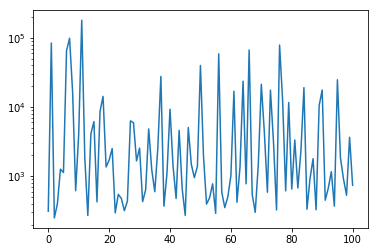

In [190]:
plt.semilogy(losses)

In [121]:
lbl.nodes[:10]

array([[ 1.        , 17.09112093,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 5.        , 13.1423759 ,  7.02356856],
       [10.        , 15.90417732, 14.17205387],
       [11.        , 10.52139226, 12.67937482],
       [ 5.        ,  9.17301394, 14.57811228],
       [ 7.        , 12.19523509,  8.4408751 ],
       [ 6.        , 11.58114125,  7.35453154],
       [ 8.        , 10.50925273,  7.70503591],
       [ 6.        , 11.58114125,  7.35453154]])

In [177]:
output = out_graphs[-1]
output.nodes[:10]

array([[ 3.21677527, 32.36051127, 34.6695294 ],
       [ 3.20182121, 32.76078406, 35.73083359],
       [ 3.20182121, 32.76078406, 35.73083359],
       [ 3.21677527, 32.36051127, 34.6695294 ],
       [ 3.21677527, 32.36051127, 34.6695294 ],
       [ 3.21677527, 32.36051127, 34.6695294 ],
       [ 3.20182121, 32.76078406, 35.73083359],
       [ 3.21677527, 32.36051127, 34.6695294 ],
       [ 3.20182121, 32.76078406, 35.73083359],
       [ 3.20182121, 32.76078406, 35.73083359]])